In [1]:
# Personalized Learning Model for Neurodivergent Students 
# Classification

# Carly Carroll

In [2]:
##### LOAD LIBRARIES ##### 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
##### LOAD CSV FILE #####

engagement_profile = pd.read_csv("engagement_profile_clean.csv")

In [4]:
##### DEFINE CLASSIFICATION TARGET ######

# binary classification target: Pass = 1, others = 0
engagement_profile['final_result_binary'] = engagement_profile['final_result'].map({
    'Pass': 1, 'Fail': 0, 'Withdrawn': 0
})

In [5]:
##### FEATURE SELECTION and CATEGORY LIMITING #####

# reduce cardinality to prevent memory issues
top_regions = engagement_profile['region'].value_counts().nlargest(5).index
engagement_profile['region'] = engagement_profile['region'].where(engagement_profile['region'].isin(top_regions), other='Other')

features = [
    'gender', 'region', 'highest_education', 'imd_band', 'age_band',
    'num_of_prev_attempts', 'studied_credits', 'sum_click'
]

X = pd.get_dummies(engagement_profile[features], drop_first=True)
y = engagement_profile['final_result_binary']

In [6]:
##### CLEANING AND SAMPLE REDUCTION #####

# drop rows with missing values
df_model = pd.concat([X, y], axis=1).dropna()
X_clean = df_model.drop('final_result_binary', axis=1)
y_clean = df_model['final_result_binary']

# reduce to 10000 samples 
if len(X_clean) > 10000:
    X_clean = X_clean.sample(10000, random_state=42)
    y_clean = y_clean.loc[X_clean.index]

In [7]:
##### TRAIN TEST SPLIT #####

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, stratify=y_clean, test_size=0.2, random_state=42
)

In [8]:
##### TRAIN MODELS #####

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       380
         1.0       0.81      1.00      0.89      1620

    accuracy                           0.81      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.66      0.81      0.72      2000


Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.37      0.18      0.24       380
         1.0       0.83      0.93      0.88      1620

    accuracy                           0.79      2000
   macro avg       0.60      0.55      0.56      2000
weighted avg       0.74      0.79      0.75      2000



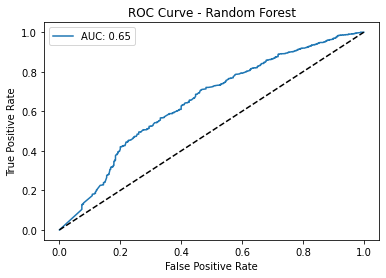

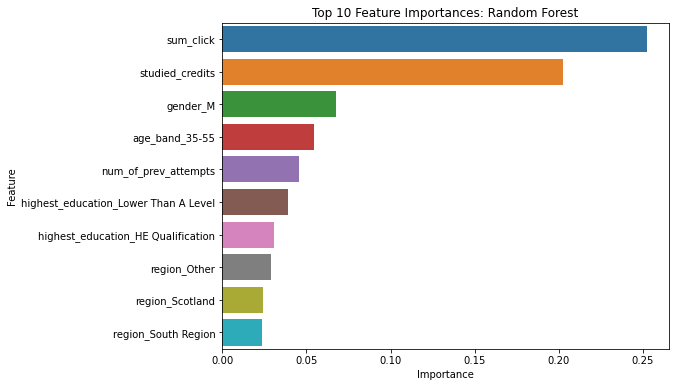

In [9]:
##### ROC CURVE AND FEATURE IMPORTANCE #####

# ROC curve for random forest
y_probs = models['Random Forest'].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC: {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# feature importance
importances = models['Random Forest'].feature_importances_
feat_df = pd.DataFrame({'Feature': X_clean.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title("Top 10 Feature Importances: Random Forest")
plt.show()

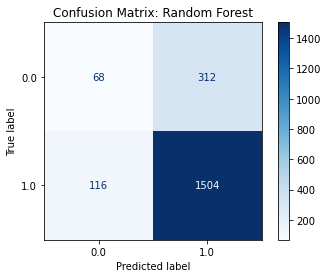

In [10]:
##### CONFUSION MATRIX #####

# for random forest
ConfusionMatrixDisplay.from_estimator(
    models["Random Forest"],
    X_test,
    y_test,
    cmap='Blues',
    values_format='d'
)
plt.title("Confusion Matrix: Random Forest")
plt.show()

In [11]:
##### COMPARE MODEL PERFORMANCE #####

model_results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    positive_class = str(sorted(y_test.unique())[-1]) 
    
    model_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": report[positive_class]['precision'] if positive_class in report else np.nan,
        "Recall": report[positive_class]['recall'] if positive_class in report else np.nan,
        "F1-Score": report[positive_class]['f1-score'] if positive_class in report else np.nan
    })

results_df = pd.DataFrame(model_results)
print(results_df.round(3))

                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression     0.807      0.809   0.996     0.893
1        Random Forest     0.786      0.828   0.928     0.875
